In [1]:
#Esto me sirve para el correcto funcionamiento de las funciones importadas en este notebook
%load_ext autoreload
%autoreload 2

# Analizando los datos

Cargamos los conjuntos de datos y librerías que se usarán en esta sección:

In [2]:
from utils.paths import crear_funcion_directorio
from utils.workit import seleccionar_cols_corr
from utils.visualize import mirar_distribuciones_num
from utils.visualize import graficar_relaciones
import pandas as pd

#Creo un acceso directo a la carpeta de data
data_dir = crear_funcion_directorio("data")

#Cargo los conjuntos de datos
df_data_jugadores_train = pd.read_csv(data_dir("processed", "df_data_jugadores_train.csv"))
df_data_jugadores_test = pd.read_csv(data_dir("processed", "df_data_jugadores_test.csv"))

## Enfocando el análisis

Dada la gran cantidad de variables númericas que tenemos, hemos decidido empezar nuestro análisis exploratorio **tomando a las columnas que presentan una mayor correlación con nuestra variable objetivo**, todo esto con el fin dde que sea un análisis más acotado y además reducir la gran dimensionalidad con la que contamos.

In [3]:
identificadores = ['seas_id', 'season', 'player_id','player', 'tm', 'pos']

df_data_jugadores_train = seleccionar_cols_corr(df = df_data_jugadores_train, var_objetivo= 'mvp_share', umbral= 0.3, columnas_ignorar= identificadores)

Notar que el umbral que consideramos para la correlación mínima **fue de 0.3**. Aunque representa una baja correlación este mismo sirve como un gran punto de partida para nuestro análisis exploratorio, posteriormente haremos una selección más refinada de columnas.

Ahora observemos el "**ranking de correlaciones**":

In [4]:
corr_matrix = df_data_jugadores_train.corr(numeric_only= True)
print(corr_matrix["mvp_share"].sort_values(ascending=False))

mvp_share       1.000000
vorp            0.553986
ws              0.508459
per             0.483577
bpm             0.470015
ws_48           0.447815
ows             0.441783
obpm            0.434651
pts_per_game    0.351145
fg_per_game     0.349332
dws             0.343751
player_id      -0.062581
seas_id        -0.067967
season         -0.072521
Name: mvp_share, dtype: float64


Podemos ver que las correlaciones "más fuertes" se dan en columnas como **'vorp'**, **'ws'** y **'per'**, para entender mejor de que van estas columnas vamos a dar algunas definiciones:

*   **'vorp' (Value over Replacement Player)**: Es una estadística avanzada que busca cuantificar el valor total que un jugador aporta a su equipo en comparación con un jugador genérico de reemplazo que estaría disponible para jugar en su lugar.

*   **'bpm' (Box Plus/Minus)**: Calcula el más/menos de un jugador respecto al rendimiento del equipo por cada 100 posesiones.

*   **'per' (Player Efficiency Rating)**: Una fórmula que calcula la **eficencia de un jugador en base a lo que produce por minuto**. El PER toma en cuenta los aciertos en tiros de campo, tiros libres, triples, asistencias, rebotes, tapones y robos, y los errores como tiros fallados, pérdidas de balón y faltas personales. La fórmula agrega estadísticas positivas y resta las negativas a través de un sistema de valores de puntos estadísticos.

*   **'ws' (Win Shares)**: Indice que reparte el éxito de un equipo entre cada uno de los jugadores, estimando el número de victorias que genera un jugador para su equipo. Una extensión de esta es **'ws_48'**, la cual consiste en lo mismo pero tomando periodos de juego de 48 minutos, ya que es lo que dura un juego NBA.

*   **'obpm' (Offensive Box Plus/Minus)**: Es una estadística que mide la contribución de un jugador en términos de puntos por encima del promedio de la liga por cada 100 posesiones jugadas, centrándose exclusivamente en su rendimiento ofensivo. Muestra cuánto un jugador mejora la producción ofensiva de su equipo cuando está en la cancha.

La correlación de estas columnas respecto a la variable objetivo **no es coincidencia**, ya que concuerda con lo que mencionamos anteriormente sobre el significado de **ser el jugador más valioso**. Se refiere a un jugador que tiene un **impacto positivo y significativo** en su equipo en comparación con sus compañeros.

## Gráficos: **mirando distribuciones**

Ahora pasamos a mirar las distribuciones de las distintas columnas, así tenemos una idea general de su comportamiento:

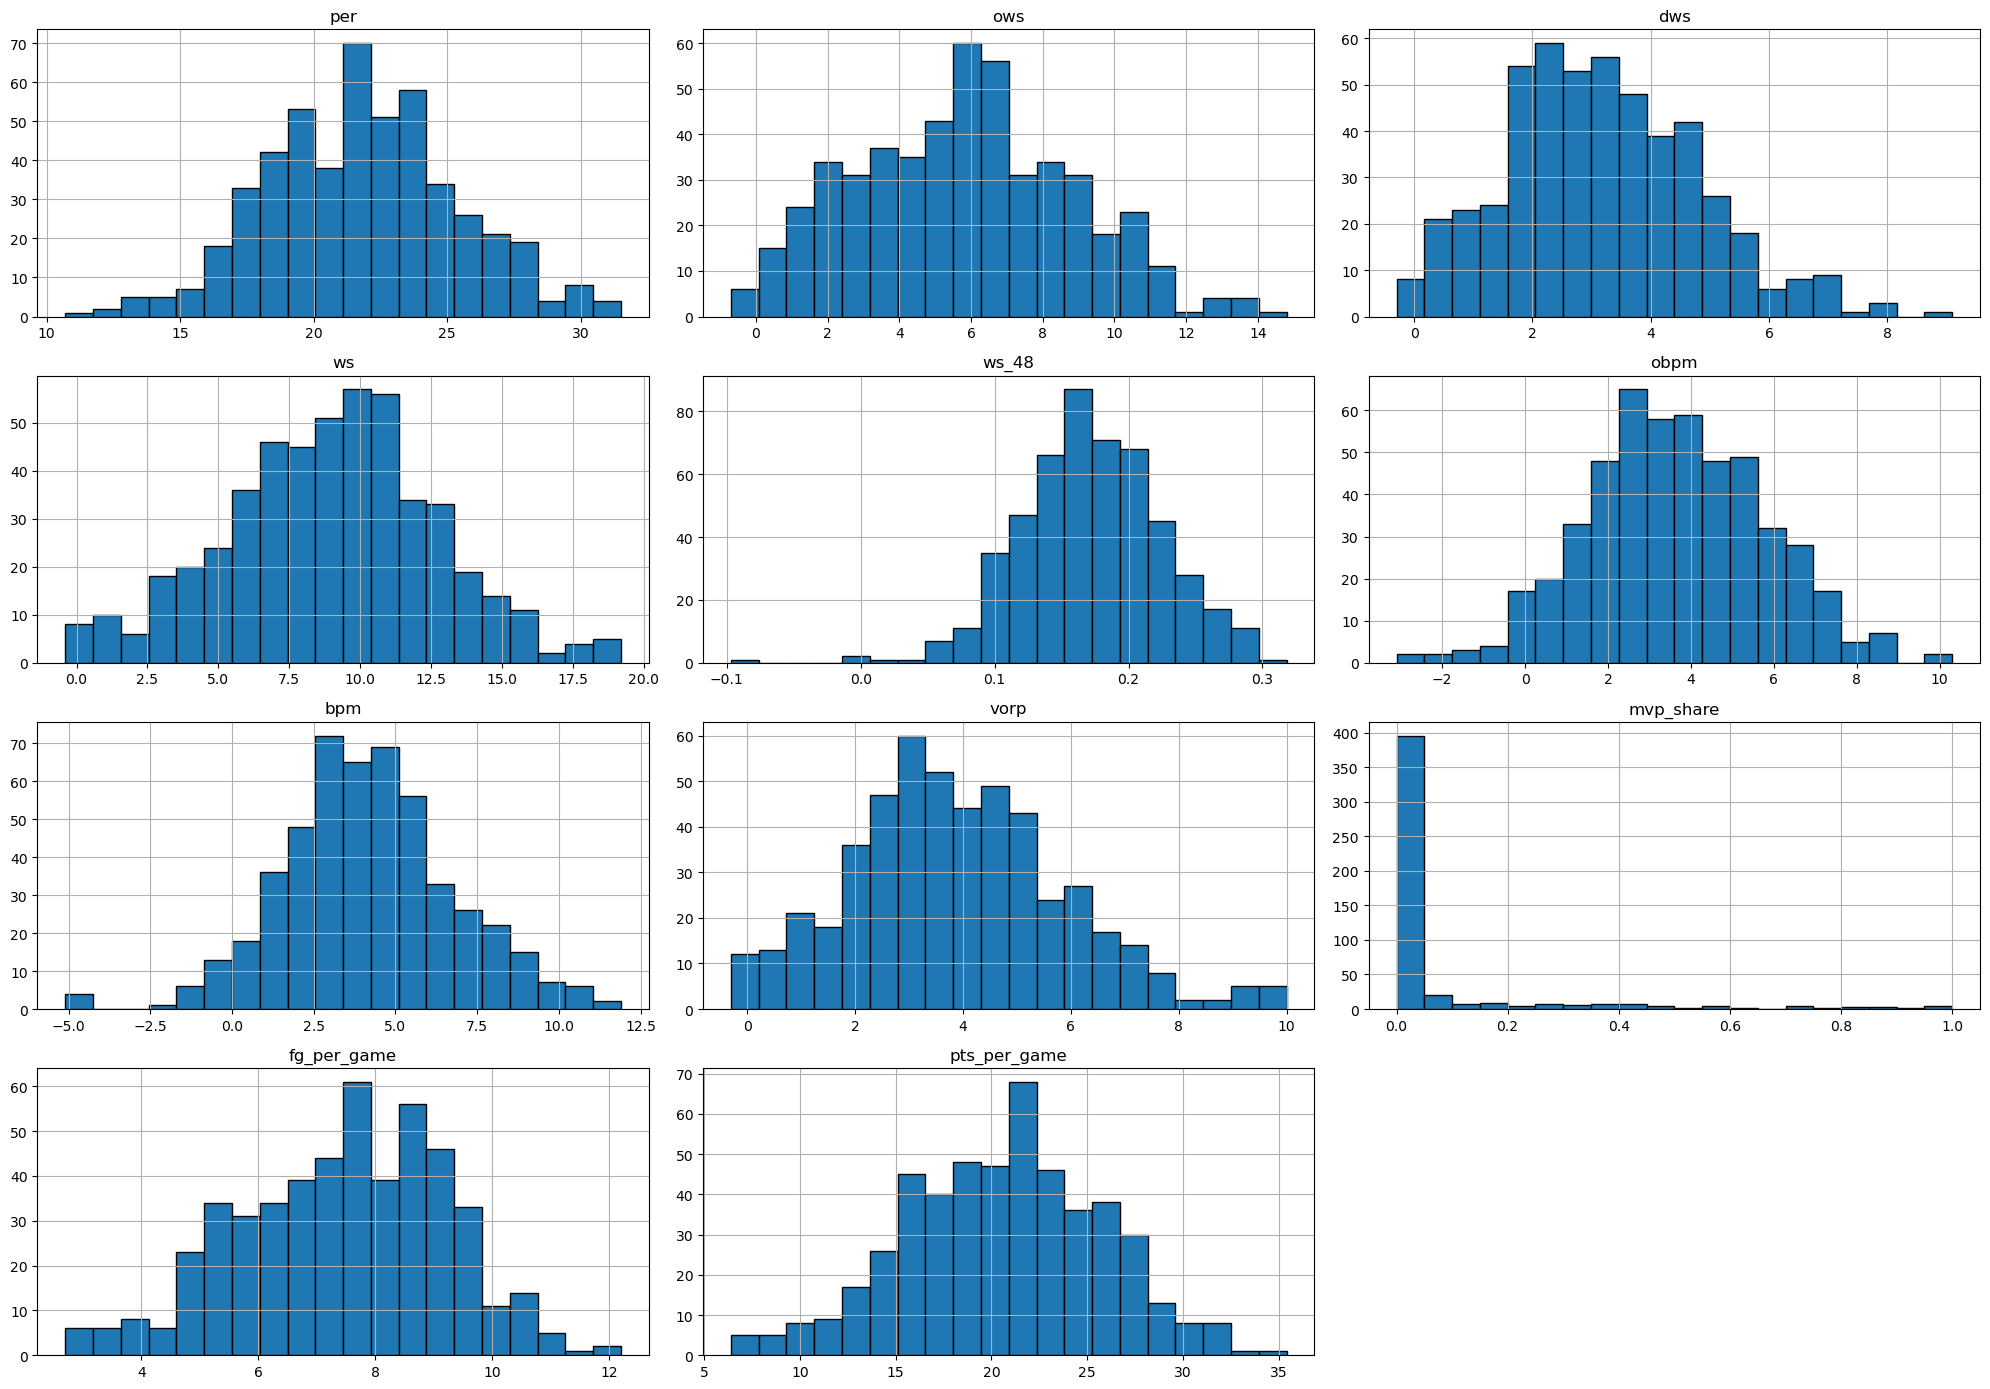

In [5]:
mirar_distribuciones_num(df = df_data_jugadores_train, tamanio = (20,14), bins= 20, columnas_ignorar= ['seas_id', 'season', 'player_id'])

En líneas generales el comportamiento de los datos se ve bastante normal, pero hay un par de casos que nos gustaría mencionar:

* En **'mvp_share'** se ve una gran acumulación de instancias en el 0, esto debido a la imputación que hicimos anteriormente
* Tanto en **'bpm'** como en **'ws_48'** hay unos valores con frecuencia bastante alejada de lo normal

Observemos que pasa con los últimos 2 casos:

In [6]:
df_data_jugadores_train[df_data_jugadores_train['bpm'] < -2.5]

,seas_id,season,player_id,player,tm,pos,per,ows,dws,ws,ws_48,obpm,bpm,vorp,mvp_share,fg_per_game,pts_per_game
162,27165,2018,4012,Isaiah Thomas,CLE,PG,12.3,-0.1,0.1,-0.1,-0.008,-1.2,-4.8,-0.3,0.0,4.7,14.7
163,27166,2018,4012,Isaiah Thomas,LAL,PG,12.8,0.0,0.2,0.2,0.024,-0.7,-4.9,-0.3,0.0,5.1,15.6
267,19916,2006,3366,Amar'e Stoudemire,PHO,C,17.8,0.0,0.1,0.1,0.085,-2.0,-4.4,0.0,0.0,3.0,8.7
295,24836,2014,3000,Kobe Bryant,LAL,SG,10.7,-0.5,0.1,-0.4,-0.097,-3.1,-5.1,-0.1,0.0,5.2,13.8


Podemos ver que los valores atípicos que vimos son de **jugadores bastante particulares**, vamos a explicar la situación de cada uno:

* Isaiah Thomas en la temporada 17-18 [fue cambiado de los Celtics a los Cavs por Kyrie Irving](https://elpais.com/deportes/2017/08/23/actualidad/1503468539_300204.html), venía de una [lesión](https://www.jugandoando.com.ar/isaiah-thomas-porque-no-juega/#:~:text=Thomas%20sufri%C3%B3%20una%20lesi%C3%B3n%20en,m%C3%A1s%20destacados%20de%20la%20liga.) que hizo que bajara drásticamente su gran nivel, lo cual explica sus valores negativos en **'bpm'** ya que su aporte fue más contraproducente 
* Amar'e Stoudemire sufrió una [esión de rodilla](https://es.wikipedia.org/wiki/Amar%27e_Stoudemire#Explosi%C3%B3n_y_lesiones_(2003-2006)) la cual fue descubierta durante la pretemporada 2005-06, la cual eventualmente sería operada causando que se perdiera casi toda la temporada, eso explica sus promedios bajos
* Kobe Bryant en la temporada 13-14 venía de sufrir [la peor lesión de su carrera, el tendón de aquiles](https://as.com/baloncesto/2013/04/14/nba/1365905066_696949.html). En esta temporada se reflejan las consecuencias de aquella lesión donde jugó bastante poco y le costó recuperar su nivel

Dadas las explicaciones y entendiendo que son situaciones **fuera del control de los jugadores**, decidimos eliminar estas instancias:

In [7]:
df_data_jugadores_train.drop(df_data_jugadores_train[df_data_jugadores_train['bpm'] < -2.5].index, inplace=True)

## Gráficos: **relaciones con la variable objetivo**

Ahora pasamos a ver gráficos de dispersión entre las distintas columnas númericas y nuestra variable objetivo, esto nos dará una idea
de la **fuerza de la correlación**:

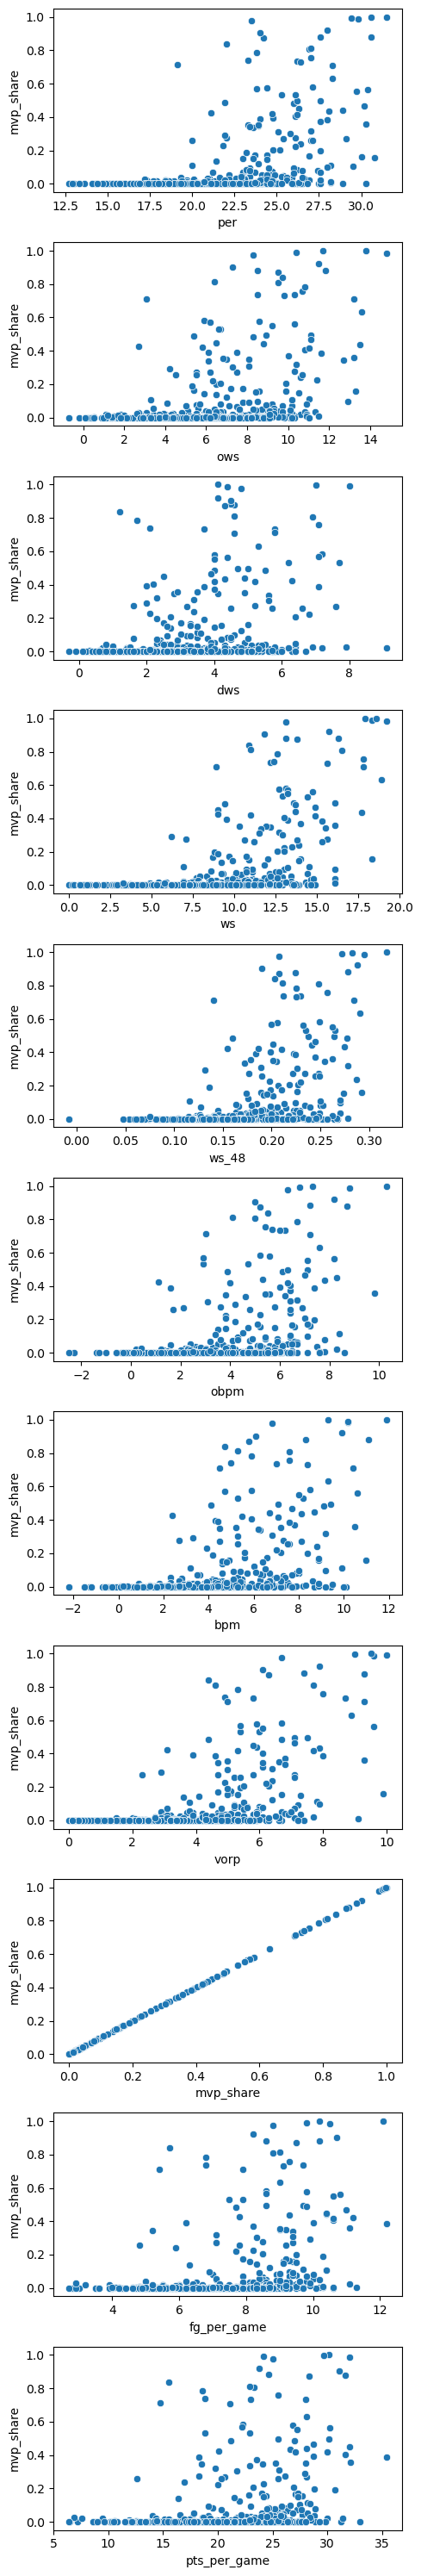

In [8]:
graficar_relaciones(df = df_data_jugadores_train, tamanio = (5, 30),columna_objetivo= 'mvp_share' ,columnas_ignorar= ['seas_id', 'season', 'player_id'])

De estos gráficos podemos hacer las siguientes observaciones:

* En cada gráfico se puede notar la presencia del 0 en **'mvp_share'**
* Todos los gráficos muestran **correlaciones positivas** que son las mismas que habíamos visto en los números, 
  pero estas no parecen ser tan fuertes, sin embargo **lo consideramos normal** dada la complejidad con la que cuenta
  nuestra variable objetivo

## Selección de features

Decidimos mantener el mismo criterio en la selección de features tomando a las columnas con una correlación mayor a 0.3, esto ya que consideramos que las variables elegidas son suficientes para pdoer entrenar un buen modelo. Por lo tanto procedemos a hacer **la separación final** tomando estas columnas:

In [9]:
selected_features = seleccionar_cols_corr(df=df_data_jugadores_train, var_objetivo='mvp_share', umbral=0.3, columnas_ignorar=[]).drop(columns=['mvp_share']).columns.tolist()

#Armo el set de entrenamiento
X_train = df_data_jugadores_train.loc[:, selected_features]
y_train = df_data_jugadores_train.loc[:, ['mvp_share']]

#Armo el set de prueba
X_test = df_data_jugadores_test.loc[:, selected_features]
y_test = df_data_jugadores_test.loc[:, ['mvp_share']]

Finalmente, guardo los conjuntos de datos **en la carpeta data**:

In [10]:
X_train.to_csv(data_dir("for_modeling", "X_train.csv"), index=False)
y_train.to_csv(data_dir("for_modeling", "y_train.csv"), index=False)
X_test.to_csv(data_dir("for_modeling", "X_test.csv"), index=False)
y_test.to_csv(data_dir("for_modeling", "y_test.csv"), index=False)
df_data_jugadores_train.to_csv(data_dir("processed", "df_data_jugadores_train.csv"), index=False)